In [1]:
from keras.models import load_model
from keras.models import Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.metrics import classification_report, confusion_matrix

import multiprocessing

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-16 13:50:56.548010: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 13:50:56.552099: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-16 13:50:56.563638: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752666656.582804  662075 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752666656.588658  662075 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-16 13:50:56.609348: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

model = load_model("../models/NoConvolutionModel.keras")
test_gen = DomainImageGenerator("prepared/test.csv", batch_size=64, shuffle=False, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

2025-07-16 13:50:59.484650: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [3]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7242 - loss: 0.5880
Test Accuracy: 0.7778
Test Loss: 0.5245


In [4]:
# Shuffle needs to be off for this to make sense. Shuffling can be done by hand with test_gen.shuffle_indexes()

test_gen.shuffle_indexes()
y_true = test_gen.getAllLabels()
y_pred = model.predict(test_gen)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


In [5]:
y_greater = y_pred[(y_pred > 0.5)]
predictions_greater_half = len(y_greater)

values = [0.6, 0.7, 0.8, 0.9, 0.95, 0.98]
print(f"There are {predictions_greater_half} predictions greater then 0.5")
for num in values:
    y_greater_num = y_greater[(y_greater > num)]
    print(f"\n{len(y_greater_num)} predictions are greater then {num}")
    print(f"That is {(len(y_greater_num)/predictions_greater_half) * 100:.1f} percent of all predictions greater then 0.5")

There are 89999 predictions greater then 0.5

89997 predictions are greater then 0.6
That is 100.0 percent of all predictions greater then 0.5

72121 predictions are greater then 0.7
That is 80.1 percent of all predictions greater then 0.5

22887 predictions are greater then 0.8
That is 25.4 percent of all predictions greater then 0.5

775 predictions are greater then 0.9
That is 0.9 percent of all predictions greater then 0.5

151 predictions are greater then 0.95
That is 0.2 percent of all predictions greater then 0.5

15 predictions are greater then 0.98
That is 0.0 percent of all predictions greater then 0.5


In [6]:
y_less = y_pred[(y_pred < 0.5)]
predictions_less_half = len(y_less)

values = [0.4, 0.3, 0.2, 0.1, 0.05, 0.02]
print(f"There are {predictions_less_half} predictions less then 0.5")
for num in values:
    y_less_num = y_less[(y_less < num)]
    print(f"\n{len(y_less_num)} predictions are smaller then {num}")
    print(f"That is {(len(y_less_num)/predictions_less_half) * 100:.1f} percent of all predictions smaller then 0.5")

There are 1 predictions less then 0.5

0 predictions are smaller then 0.4
That is 0.0 percent of all predictions smaller then 0.5

0 predictions are smaller then 0.3
That is 0.0 percent of all predictions smaller then 0.5

0 predictions are smaller then 0.2
That is 0.0 percent of all predictions smaller then 0.5

0 predictions are smaller then 0.1
That is 0.0 percent of all predictions smaller then 0.5

0 predictions are smaller then 0.05
That is 0.0 percent of all predictions smaller then 0.5

0 predictions are smaller then 0.02
That is 0.0 percent of all predictions smaller then 0.5


In [7]:
print(classification_report(y_true, y_pred_binary, target_names=["CIFAR-10", "ImageNet"]))

              precision    recall  f1-score   support

    CIFAR-10       0.00      0.00      0.00     20000
    ImageNet       0.78      1.00      0.87     70000

    accuracy                           0.78     90000
   macro avg       0.39      0.50      0.44     90000
weighted avg       0.60      0.78      0.68     90000



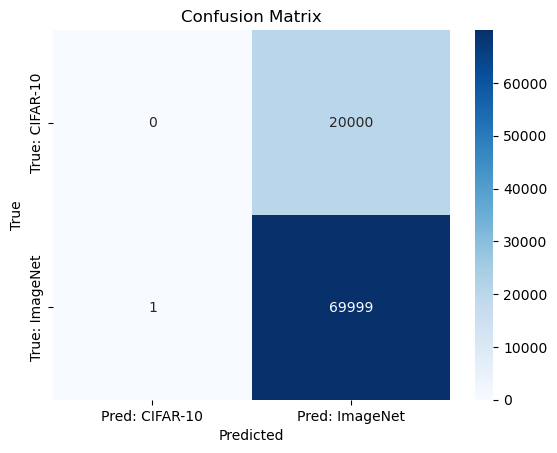

In [8]:
cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: CIFAR-10", "Pred: ImageNet"],
            yticklabels=["True: CIFAR-10", "True: ImageNet"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [9]:
indexes = test_gen.return_Indexes()
categories = test_gen.return_Category_by_Index(indexes)

In [10]:
# Build the DataFrame
df_images = pd.DataFrame({
    "index": indexes,
    "category": categories,
    "y_true": y_true,
    "prediction": y_pred.flatten()
})

In [11]:
df_cifar = df_images[df_images["y_true"] == 0].copy()
df_imagenet = df_images[df_images["y_true"] == 1].copy()

In [12]:
print(f"CIFAR-10: {len(df_cifar)} images")
print(f"ImageNet: {len(df_imagenet)} images")

print(df_cifar.head())
print(df_imagenet.head())

CIFAR-10: 20000 images
ImageNet: 70000 images
    index  category  y_true  prediction
1   72169      ship       0    0.830615
3   55716      frog       0    0.749678
8     758  airplane       0    0.768344
17     70  airplane       0    0.778723
20  19655      bird       0    0.699467
   index category  y_true  prediction
0  34314      cat       1    0.824364
2  66900    horse       1    0.748367
4  26272     bird       1    0.788008
5  30426      cat       1    0.749009
6  24405     bird       1    0.699467


In [13]:
print(np.unique(df_images["category"]))

['airplane' 'automobile' 'bird' 'cat' 'deer' 'dog' 'frog' 'horse' 'ship'
 'truck']


In [14]:
def from_DataFrame_get_subDataFrame_of_category(df, category):
    return df[df["category"] == category]

Loading images: 100%|███████████████████████████| 8/8 [00:00<00:00, 1544.15it/s]


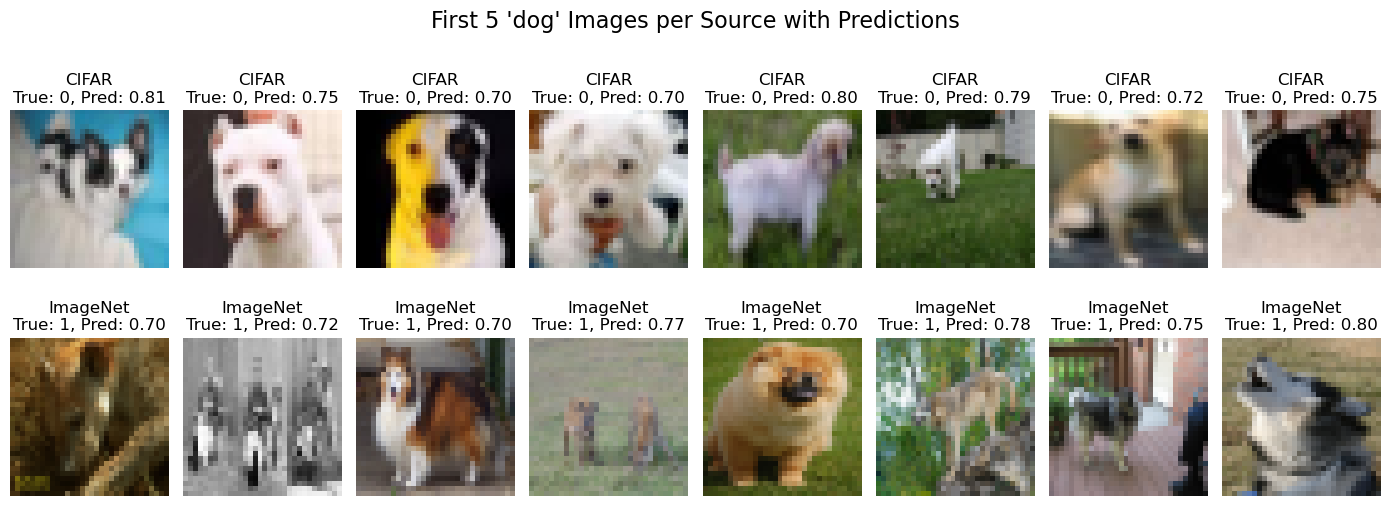

In [15]:
category = "dog"
picture_count = 8
start_idx_cifar = 8
start_idx_imagenet = 64
fig, axs = plt.subplots(2, picture_count, figsize=(14, 5))

# Filter sub-DataFrames
cifar_sub_df = from_DataFrame_get_subDataFrame_of_category(df_cifar, category)
imagenet_sub_df = from_DataFrame_get_subDataFrame_of_category(df_imagenet, category)

# Get images by index
cifar_images = test_gen.return_Img_by_Index(cifar_sub_df["index"][start_idx_cifar:picture_count+start_idx_cifar])
imagenet_images = test_gen.return_Img_by_Index(imagenet_sub_df["index"][start_idx_imagenet:picture_count+start_idx_imagenet])

# CIFAR-10 (top row)
for i in range(picture_count):
    img = cifar_images[i]
    row = cifar_sub_df.iloc[i]
    title = f"CIFAR\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[0, i].imshow(img)
    axs[0, i].set_title(title)
    axs[0, i].axis("off")

# ImageNet (bottom row)
for i in range(picture_count):
    img = imagenet_images[i]
    row = imagenet_sub_df.iloc[i]
    title = f"ImageNet\nTrue: {int(row['y_true'])}, Pred: {row['prediction']:.2f}"
    axs[1, i].imshow(img)
    axs[1, i].set_title(title)
    axs[1, i].axis("off")

plt.tight_layout()
plt.suptitle(f"First 5 '{category}' Images per Source with Predictions", y=1.08, fontsize=16)
plt.show()

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       786,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,459,141 (9.38 MB)

 Trainable params: 819,713 (3.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,639,428 (6.25 MB)